In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scanpy as sc
import os
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import harmonypy as hm

from matplotlib import rcParams
from pathlib import Path
from tqdm import tqdm

import iSp3D as MODEL
from iSp3D import Func
from iSp3D import iSpaNet
from iSp3D.Classifier import iSpaNetClassifier
from iSp3D.Utils import align_spatial_slices
from iSp3D.Attribution import compute_and_summary_by_cluster
from iSp3D.Metrics import compute_ARI, compute_NMI, compute_HOM, compute_COM, compute_PAS, compute_CHAOS
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.decomposition import PCA

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['R_HOME'] = r'C:\Program Files\R\R-4.4.2'
os.environ['R_USER'] = r'C:\Users\CLEARLOVE\.conda\envs\STG\Lib\site-packages\rpy2'


def mapping2int(string_array):
    mapping = {}
    result = []
    for string in string_array:
        if string not in mapping:
            mapping[string] = len(mapping)
        result.append(mapping[string])
    return result, mapping


def inverse_pca_transform(pca, recon_pca_data):
    recon_original = pca.inverse_transform(recon_pca_data)
    return recon_original

def compute_fscoreLISI(Tmp_adata, LT_key, BT_key, PD_key):
    LISI_batch_norm = hm.compute_lisi(Tmp_adata.obsm[LT_key], Tmp_adata.obs[[BT_key]], label_colnames=[BT_key])[:, 0]
    LISI_domain_norm = hm.compute_lisi(Tmp_adata.obsm[LT_key], Tmp_adata.obs[[PD_key]], label_colnames=[PD_key])[:, 0]

    LISI = 2 * (1 / LISI_domain_norm) * LISI_batch_norm / (1 / LISI_domain_norm + LISI_batch_norm)
    return LISI


In [2]:
def get_data(proj_list, config):
    global graph_dict
    data_root = Path(r'C:\Code\Data\MERFISH')
    result, mapping = mapping2int(proj_list)
    for proj_name in tqdm(proj_list):
        adata_tmp = sc.read_h5ad(os.path.join(r"C:\Code\Data\MERFISH\hypothalamus-" + proj_name + ".h5ad"))
        adata_tmp.var_names_make_unique()

        adata_tmp.obs['batch_name'] = proj_name
        adata_tmp.obs['slice_id'] = mapping[proj_name]

        graph_dict_tmp = Func.graph_construction(adata_tmp, config['k_cutoff'])
        if proj_name == proj_list[0]:
            adata = adata_tmp
            graph_dict = graph_dict_tmp
            name = proj_name
            adata.obs['proj_name'] = proj_name
        else:
            var_names = adata.var_names.intersection(adata_tmp.var_names)
            adata = adata[:, var_names]
            adata_tmp = adata_tmp[:, var_names]
            adata_tmp.obs['proj_name'] = proj_name

            adata = adata.concatenate(adata_tmp)
            graph_dict = Func.combine_graph_dict(graph_dict, graph_dict_tmp)
            name = name + '_' + proj_name

    adata.layers['count'] = adata.X.toarray()
    sc.pp.filter_genes(adata, min_cells=50)
    sc.pp.filter_genes(adata, min_counts=10)
    sc.pp.normalize_total(adata, target_sum=1e6)
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=155)
    adata = adata[:, adata.var['highly_variable'] == True]
    sc.pp.scale(adata)

    adata.obsm['X_original'] = adata.X.copy()
    n_samples, n_features = adata.shape
    n_components = min(200, n_samples, n_features)
    pca = PCA(n_components=n_components, random_state=42)
    adata_X = pca.fit_transform(adata.X)
    adata.obsm['X_pca'] = adata_X
    return adata, graph_dict, pca

In [3]:
with open(r'C:\Code\iSpa3D\Config\Config_MF.yaml', 'r', encoding='utf-8') as f:
    config = yaml.load(f.read(), Loader=yaml.FullLoader)

In [4]:
proj_list = ['0.04', '0.09', '0.14', '0.19', '0.24']
adata, graph_dict, pca = get_data(proj_list, config['data'])

100%|██████████| 5/5 [00:14<00:00,  2.92s/it]


In [5]:
num_cluster = config['model']['class_num']
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
net = MODEL.G3net(adata, graph_dict=graph_dict, device=device, config=config, num_cluster=num_cluster)

In [6]:
method = 'mclust'

In [7]:
net.train()

Epoch 495 total loss=3.307 recon loss=0.962 tri loss=0.000 disc loss=1.421 cluster loss=2.709:  50%|████▉     | 499/1000 [00:40<00:39, 12.76it/s]R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


Epoch 545 total loss=3.511 recon loss=1.004 tri loss=0.192 disc loss=1.645 cluster loss=2.617:  55%|█████▌    | 550/1000 [01:22<00:54,  8.33it/s]

fitting ...
  |======================================================================| 100%


Epoch 595 total loss=3.461 recon loss=0.989 tri loss=0.195 disc loss=1.623 cluster loss=2.575:  60%|██████    | 600/1000 [02:00<00:50,  7.87it/s]  

fitting ...
  |======================================================================| 100%


Epoch 645 total loss=3.427 recon loss=0.986 tri loss=0.181 disc loss=1.616 cluster loss=2.549:  65%|██████▌   | 650/1000 [02:40<00:47,  7.39it/s]  

fitting ...
  |======================================================================| 100%


Epoch 695 total loss=3.394 recon loss=0.985 tri loss=0.175 disc loss=1.614 cluster loss=2.515:  70%|███████   | 700/1000 [03:17<00:40,  7.40it/s]

fitting ...
  |======================================================================| 100%


Epoch 745 total loss=3.381 recon loss=0.984 tri loss=0.180 disc loss=1.610 cluster loss=2.498:  75%|███████▌  | 750/1000 [04:01<00:30,  8.15it/s]

fitting ...
  |======================================================================| 100%


Epoch 795 total loss=3.384 recon loss=0.989 tri loss=0.178 disc loss=1.626 cluster loss=2.489:  80%|████████  | 800/1000 [04:38<00:24,  8.06it/s]

fitting ...
  |======================================================================| 100%


Epoch 845 total loss=3.363 recon loss=0.985 tri loss=0.175 disc loss=1.605 cluster loss=2.483:  85%|████████▌ | 850/1000 [05:20<00:18,  8.03it/s]

fitting ...
  |======================================================================| 100%


Epoch 895 total loss=3.362 recon loss=0.980 tri loss=0.179 disc loss=1.610 cluster loss=2.476:  90%|█████████ | 900/1000 [05:57<00:12,  8.17it/s]

fitting ...
  |======================================================================| 100%


Epoch 945 total loss=3.363 recon loss=0.987 tri loss=0.183 disc loss=1.612 cluster loss=2.471:  95%|█████████▌| 950/1000 [06:31<00:06,  7.93it/s]

fitting ...
  |======================================================================| 100%


Epoch 995 total loss=3.353 recon loss=0.988 tri loss=0.175 disc loss=1.606 cluster loss=2.470: 100%|██████████| 1000/1000 [07:11<00:00,  2.32it/s]


In [8]:
enc_rep, recon = net.process()
enc_rep = enc_rep.data.cpu().numpy()
recon = recon.data.cpu().numpy()
adata.obsm['latent'] = enc_rep
adata.obsm['recon'] = recon
recon_original = inverse_pca_transform(pca, recon)
adata.obsm['X_reconstructed'] = recon_original
adata = net.clustering(adata, num_cluster=num_cluster, used_obsm='latent', key_added_pred='mclust', method='mclust', random_seed=666)
print(adata)

fitting ...
  |======================================================================| 100%
AnnData object with n_obs × n_vars = 28317 × 155
    obs: 'cell_class', 'Neuron_cluster_ID', 'array_row', 'array_col', 'layer_guess', 'batch_name', 'slice_id', 'proj_name', 'batch', 'Tmp_domain', 'mclust'
    var: 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg'
    obsm: 'spatial', 'X_original', 'X_pca', 'latent', 'recon', 'X_reconstructed'
    layers: 'count'


In [9]:
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
ARI = ari_score(sub_adata.obs['layer_guess'], sub_adata.obs['mclust'])
print(f"total ARI:{ARI}")
for name in proj_list:
    sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
    ARI = ari_score(sub_adata_tmp.obs['layer_guess'], sub_adata_tmp.obs['mclust'])
    print(f"{name} ARI:{ARI}")

total ARI:0.5617739722578283
0.04 ARI:0.5429400404207543
0.09 ARI:0.570598941461137
0.14 ARI:0.502779839426529
0.19 ARI:0.622348029544792
0.24 ARI:0.6360635285104587


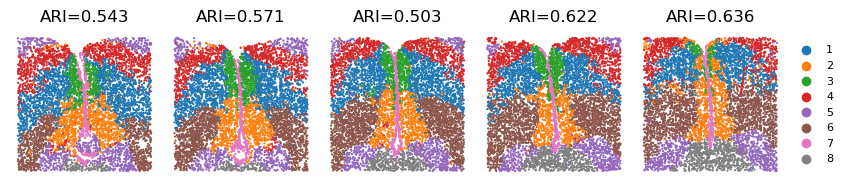

In [10]:
import matplotlib.pyplot as plt

Batch_list = []

for section_id in proj_list:
    Batch_list.append(adata[adata.obs['batch_name'] == section_id])

spot_size = 30
title_size = 12
ARI_list = []
for bb in range(len(proj_list)):
    ARI_list.append(round(ari_score(Batch_list[bb].obs['layer_guess'], Batch_list[bb].obs['mclust']), 3))

fig, ax = plt.subplots(1, 5, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
for idx in range(len(proj_list)):
    # 仅在最后一个子图显示图例
    show_legend = (idx == len(proj_list) - 1)  # True for last subplot

    _sc_ = sc.pl.spatial(
        Batch_list[idx],
        img_key=None,
        color=['mclust'],
        title=[''],
        legend_loc='right margin' if show_legend else None,  # 控制图例显示
        legend_fontsize=8,  # 调整图例字体大小
        show=False,
        ax=ax[idx],
        frameon=False,
        spot_size=spot_size
    )
    _sc_[0].set_title("ARI=" + str(ARI_list[idx]), size=title_size)

plt.tight_layout()  # 调整布局防止图例重叠
plt.show()

In [12]:
import matplotlib

def vertical_alignment_on_adata(adata, proj_list_str, batch_key="slice_name", coor_key='spatial', align=True, plot=False):
    plt.rcParams.update({
        'figure.facecolor': 'white',
        'axes.facecolor': 'white',
        'axes.edgecolor': 'black',
        'axes.labelcolor': 'black',
        'xtick.color': 'black',
        'ytick.color': 'black',
        'font.size': 16,
        'axes.titlesize': 18,
        'axes.labelsize': 16,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        'legend.fontsize': 14,
        'legend.title_fontsize': 15
    })

    unique_slices = proj_list_str
    spatial_aligned = np.zeros((adata.shape[0], 3))  # 初始化新坐标

    if plot:
        # Custom color palette from the image
        custom_colors = [
            (97/255, 108/255, 140/255),
            (86/255, 140/255, 135/255),
            (178/255, 213/255, 155/255),
            (242/255, 222/255, 121/255),
            (217/255, 95/255, 24/255)
        ]

        colors_list = [matplotlib.colors.rgb2hex(color) for color in custom_colors]

        fig, ax = plt.subplots(figsize=(9, 6))
        fig.patch.set_facecolor('white')
        ax.set_facecolor('white')

        ax.set_title("Before alignment", pad=20)
        for i, sid in enumerate(unique_slices):
            sub = adata[adata.obs[batch_key] == sid]
            ax.scatter(sub.obsm[coor_key][:, 0], sub.obsm[coor_key][:, 1],
                      c=colors_list[i], label=f"Slice {sid}", s=8., alpha=0.7)

        ax.set_xlabel("X coordinate")
        ax.set_ylabel("Y coordinate")
        ax.tick_params(axis='both', which='major')
        ax.set_ylim(ax.get_ylim()[::-1])

        # Create custom legend with rectangles
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor=color, edgecolor='black',
                             label=f'Slice {sid}')
                        for sid, color in zip(unique_slices, colors_list)]

        legend = ax.legend(
            handles=legend_elements,
            loc='upper left',
            frameon=True,
            framealpha=1,
            edgecolor='white',
            facecolor='white',
            bbox_to_anchor=(1.02, 1),
            borderaxespad=0.,
            title='Slices'
        )

        plt.setp(legend.get_title(), fontweight='bold')
        plt.tight_layout(rect=[0, 0, 0.85, 1])
        plt.savefig('before_alignment.pdf', bbox_inches='tight', dpi=300)
        plt.show()

    ref_slice = unique_slices[0]
    ref = adata[adata.obs[batch_key] == ref_slice]
    ref_x = ref.obs["array_row"].mean()
    ref_y = ref.obs["array_col"].mean()

    for i, slice_id in enumerate(unique_slices):
        z_val = i * 100
        sub_idx = adata.obs[batch_key] == slice_id
        sub_data = adata[sub_idx]

        x = sub_data.obs["array_row"].copy()
        y = sub_data.obs["array_col"].copy()

        if align and slice_id != ref_slice:
            dx = ref_x - x.mean()
            dy = ref_y - y.mean()
            x += dx
            y += dy

        spatial_aligned[sub_idx.values, 0] = x.values
        spatial_aligned[sub_idx.values, 1] = y.values
        spatial_aligned[sub_idx.values, 2] = z_val

    adata.obsm["spatial_aligned"] = spatial_aligned

    if plot:
        fig, ax = plt.subplots(figsize=(9, 6))
        fig.patch.set_facecolor('white')
        ax.set_facecolor('white')

        ax.set_title("After alignment", pad=20)
        for i, sid in enumerate(unique_slices):
            sub = adata[adata.obs[batch_key] == sid]
            coords = sub.obsm["spatial_aligned"]
            ax.scatter(coords[:, 0], coords[:, 1],
                      c=colors_list[i], label=f"Slice {sid}", s=8., alpha=0.7)

        ax.set_xlabel("Aligned X coordinate")
        ax.set_ylabel("Aligned Y coordinate")
        ax.tick_params(axis='both', which='major')
        ax.set_ylim(ax.get_ylim()[::-1])

        # Create custom legend with rectangles for the after-alignment plot
        legend_elements = [Patch(facecolor=color, edgecolor='black',
                             label=f'Slice {sid}')
                        for sid, color in zip(unique_slices, colors_list)]

        legend = ax.legend(
            handles=legend_elements,
            loc='upper left',
            frameon=True,
            framealpha=1,
            edgecolor='white',  # Changed to gray
            facecolor='white',
            bbox_to_anchor=(1.02, 1),
            borderaxespad=0.,
            title='Slices'
        )

        plt.setp(legend.get_title(), fontweight='bold')
        plt.tight_layout(rect=[0, 0, 0.85, 1])
        # plt.savefig('after_alignment.pdf', bbox_inches='tight', dpi=300)
        plt.show()

    return adata

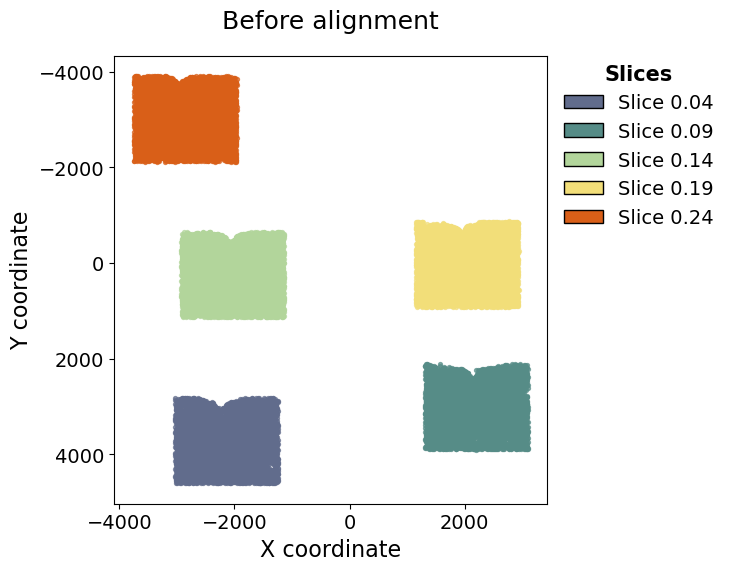

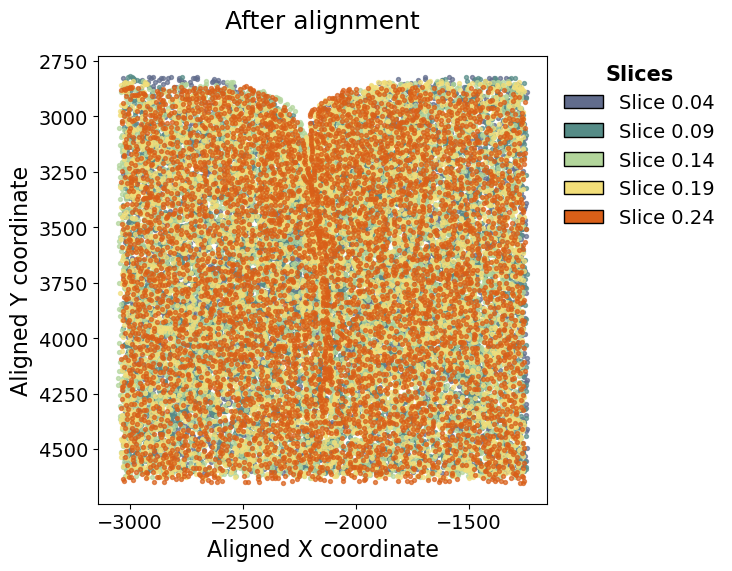

In [13]:
adata = vertical_alignment_on_adata(adata, proj_list, batch_key='batch_name', plot=True)

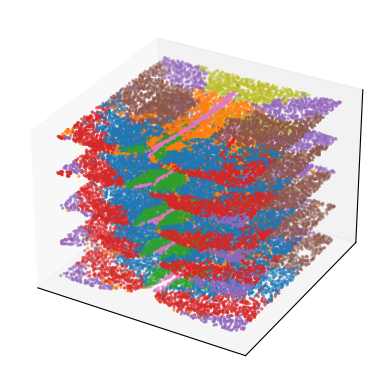

In [14]:
colors_default = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
    '#9467bd', '#8c564b', '#e377c2', '#bcbd22'
]


def set_fixed_colors(adata, key, colors=colors_default):
    unique_labels = list(adata.obs[key].unique())
    unique_labels.sort()  
    n_labels = len(unique_labels)
    color_map = dict(zip(unique_labels, colors[:n_labels]))
    adata.uns[key + "_colors"] = [color_map[label] for label in adata.obs[key].cat.categories]

set_fixed_colors(adata, key="mclust", colors=colors_default)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sc.pl.embedding(
    adata,
    basis="spatial_aligned",
    projection="3d",
    color="mclust",
    ax=ax,
    show=False,
    legend_loc=None 
)

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_zlabel('')
ax.set_title('')

ax.set_facecolor("white")
fig.patch.set_facecolor("white")

# plt.savefig('spatial_3d.png', format='png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()
plt.close(fig)